In [ ]:
#importing Libraries
import pickle
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta
import gc
from sklearn.model_selection import train_test_split,KFold,GroupKFold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

> Function to reduce memory usage

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train_data = pd.read_feather('/content/drive/MyDrive/ashrae_Great_Energy_Prediction/train_data_imputed.feather')
train_data.drop('level_0',axis=1,inplace=True)

In [ ]:
train_data = reduce_mem_usage(train_data)

Mem. usage decreased to 958.11 Mb (0.0% reduction)


In [ ]:
train_data.head()

,index,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day,month
0,103,105,0,2016-01-01,23.303600,1,Education,50623,1960.0,3.800781,6.0,2.400391,0.0,1021.0,240.0,3.099609,1,1
1,104,106,0,2016-01-01,0.374600,1,Education,5374,1960.0,3.800781,6.0,2.400391,0.0,1021.0,240.0,3.099609,1,1
2,105,106,3,2016-01-01,0.000000,1,Education,5374,1960.0,3.800781,6.0,2.400391,0.0,1021.0,240.0,3.099609,1,1
3,106,107,0,2016-01-01,175.184006,1,Education,97532,2005.0,3.800781,6.0,2.400391,0.0,1021.0,240.0,3.099609,1,1
4,107,108,0,2016-01-01,91.265297,1,Education,81580,1913.0,3.800781,6.0,2.400391,0.0,1021.0,240.0,3.099609,1,1


In [ ]:
# converting timestamp to datetime object
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])

##LabelEncoding primary_use feature

In [ ]:
le = LabelEncoder()
train_data['primary_use'] = le.fit_transform(train_data['primary_use'])

## Alignment of air_temperature according to local_temperature

In [ ]:
align_hours = {0:5,2:9,3:5,4:8,6:6,7:6,8:5,9:7,10:8,11:6,13:7,14:5,15:5} 
def alignment(data,align_hours):
    data.reset_index(inplace=True)
    data['timestamp_alignment'] = data['timestamp'] - timedelta(hours=align_hours)
    data_air_temp = data[['timestamp_alignment','building_id','meter','air_temperature']].copy()
    data.drop(['air_temperature','timestamp_alignment'],axis=1,inplace=True)
    data['air_temperature_alignment'] = data_air_temp[data_air_temp['timestamp_alignment'].isin(data['timestamp'])].reset_index(drop=True)['air_temperature']
    data['air_temperature_alignment'] = data['air_temperature_alignment'].interpolate()
    data.rename(columns={'air_temperature_alignment':'air_temperature','timestamp_alignment':'timestamp'},inplace=True)
    data.drop(['level_0','index'],axis=1,inplace=True)
    return data

In [ ]:
def no_alignment(data):
    data.reset_index(inplace=True)
    data.drop(['level_0','index'],axis=1,inplace=True)
    return data

In [ ]:
#air_temperature maximizes around 19:00PM to 23:00PM for 13 different sites which needs to be corrected 
#so that the model can best identify the energy pattern according to the temperature variations over the hour

air_temp_site_0_alignment = alignment(train_data.query(f'site_id==0'),5)
air_temp_site_1_alignment = no_alignment(train_data.query(f'site_id==1'))
air_temp_site_2_alignment = alignment(train_data.query(f'site_id==2'),9)
air_temp_site_3_alignment = alignment(train_data.query(f'site_id==3'),5)
air_temp_site_4_alignment = alignment(train_data.query(f'site_id==4'),8)
air_temp_site_5_alignment = no_alignment(train_data.query(f'site_id==5'))
air_temp_site_6_alignment = alignment(train_data.query(f'site_id==6'),6)
air_temp_site_7_alignment = alignment(train_data.query(f'site_id==7'),6)
air_temp_site_8_alignment = alignment(train_data.query(f'site_id==8'),5)
air_temp_site_9_alignment = alignment(train_data.query(f'site_id==9'),7)
air_temp_site_10_alignment = alignment(train_data.query(f'site_id==10'),8)
air_temp_site_11_alignment = alignment(train_data.query(f'site_id==11'),6)
air_temp_site_12_alignment = no_alignment(train_data.query(f'site_id==12'))
air_temp_site_13_alignment = alignment(train_data.query(f'site_id==13'),7)
air_temp_site_14_alignment = alignment(train_data.query(f'site_id==14'),5)
air_temp_site_15_alignment = alignment(train_data.query(f'site_id==15'),5)

In [ ]:
train_data_final = pd.concat([air_temp_site_0_alignment,air_temp_site_1_alignment,air_temp_site_2_alignment,air_temp_site_3_alignment,air_temp_site_4_alignment,air_temp_site_5_alignment,air_temp_site_6_alignment,air_temp_site_7_alignment,air_temp_site_8_alignment,air_temp_site_9_alignment,air_temp_site_10_alignment,air_temp_site_11_alignment,air_temp_site_12_alignment,air_temp_site_13_alignment,air_temp_site_14_alignment,air_temp_site_15_alignment],axis=0)

In [ ]:
#sort datapoints based on timestamp,building_id
train_data_final = train_data_final.sort_values(['timestamp','building_id'])

In [ ]:
train_data_final['hour'] = train_data_final['timestamp'].dt.hour
train_data_final['weekday'] = train_data_final['timestamp'].dt.weekday

* During day time in working hours the meter readings are high.
* when compared the days of week the weekdays have more meter readings than weekands. 

In [ ]:
train_data_final['is_winter_month']=(train_data_final['month'].isin([12,1,2])).astype(int)
train_data_final['is_summer_month']=(train_data_final['month'].isin([6,7,8])).astype(int)

* chilled water readings are low during winter and high during summer.
* Hot water readings are low during summer and high during summer.

In [ ]:
train_data_final = reduce_mem_usage(train_data_final)

Mem. usage decreased to 976.90 Mb (40.2% reduction)


In [ ]:
holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
            "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-25"]
h_date = pd.to_datetime(holidays,yearfirst=True)
train_data_final['is_pub_holiday'] = train_data_final['timestamp'].dt.date.isin(h_date.date).astype(int)
train_data_final['is_weekday'] = ((~train_data_final['timestamp'].dt.date.isin(h_date.date))&(train_data_final['weekday'].isin([0,1,2,3,4]))).astype(int)

* Energy requirements might be different from holidays to working days.

In [ ]:
train_data_final = reduce_mem_usage(train_data_final)

Mem. usage decreased to 1014.47 Mb (20.6% reduction)


In [ ]:
#https://www.kaggle.com/c/ashrae-energy-prediction/discussion/124984

#horizsolar is supposed to calculate the solar horizontal radiation coming into the building.
latitude_dict = {0 :28.5383,1 :50.9097,2 :33.4255,3 :38.9072,4 :37.8715,5 :50.9097,6 :40.7128,7 :45.4215,8 :28.5383,9 :30.2672,10 :40.10677,11 :45.4215,12 :53.3498,13 :44.9375,14 :38.0293,15: 40.7128,}

train_data_final['latitude'] = train_data_final['site_id'].map(latitude_dict)
train_data_final['solarHour'] = (train_data_final['hour']-12)*15 
train_data_final['solarDec'] = -23.45*np.cos(np.deg2rad(360*(train_data_final['day']+10)/365)) 
train_data_final['horizsolar'] = np.cos(np.deg2rad(train_data_final['solarHour']))*np.cos(np.deg2rad(train_data_final['solarDec']))*np.cos(np.deg2rad(train_data_final['latitude'])) + np.sin(np.deg2rad(train_data_final['solarDec']))*np.sin(np.deg2rad(train_data_final['latitude']))
train_data_final['horizsolar'] = train_data_final['horizsolar'].apply(lambda x: 0 if x <0 else x)

train_data_final = train_data_final.drop(['latitude','solarHour','solarDec'], axis=1)
    # The sensible heat is a form of energy emitted into the atmosphere or absorbed
train_data_final['Sensible_Heat'] = 0.5274*(10.**(-4.))*train_data_final['square_feet']*(75.-train_data_final['air_temperature'])

train_data_final['relative_humidity'] = 100 * (np.exp((17.625 * train_data_final['dew_temperature']) / (243.04 + train_data_final['dew_temperature'])) / np.exp((17.625 * train_data_final['air_temperature'])/(243.04 + train_data_final['air_temperature'])))

* Humidity affects the energy requirements of the buildings. As humidity increases the load on the HVAC system increases due to which the meter readings are affected. so this feature will help to learn the energy requirements according to the humidity.


In [ ]:
train_data_final['log_meter_reading'] = np.log1p(train_data_final['meter_reading'])

In [ ]:
#https://journals.sagepub.com/doi/pdf/10.1177/1550147719877616
#https://en.wikipedia.org/wiki/Wind_chill

train_data_final['discomfort_index'] = (1.8*train_data_final['air_temperature'] + 32) - ((0.55-0.0055*train_data_final['relative_humidity'])*(1.8 * train_data_final['air_temperature'] - 26))
train_data_final['wind_chill'] = 13.12 + 0.6215*train_data_final['air_temperature'] - 11.37*(train_data_final['wind_speed']**0.16) + 0.3965*train_data_final['air_temperature']*(train_data_final['wind_speed']**0.16)

* As the air_temperature falls, the chilling effect of any wind that is present increases.
* As index for measuring the discomfort felt in warm weather as a result of the combined effects of the temperature and humidity of the air.

In [ ]:
busy_hours = train_data_final.set_index(['timestamp']).between_time('06:00:00','18:00:00').reset_index()
busy_hours_timestamp = [i for i in busy_hours['timestamp']]
train_data_final['busy_hour']=((~train_data_final['timestamp'].dt.date.isin(h_date.date))&(train_data_final['timestamp'].isin(busy_hours_timestamp))).astype(int)


* As the meter_readings are high during day time than night.

In [ ]:
train_data_final = train_data_final.reset_index()
train_data_final.to_feather('/content/drive/MyDrive/ashrae_Great_Energy_Prediction/train_feature_engineering.feather')

In [ ]:
data = pd.read_feather('/content/drive/MyDrive/ashrae_Great_Energy_Prediction/train_feature_engineering.feather')
data.drop('index',axis=1,inplace=True)

In [ ]:
x = data.drop(['timestamp','log_meter_reading','meter_reading'],axis=1)
y = data['log_meter_reading']

In [ ]:
categorical_cols = ['building_id','meter','site_id','month','year_bulit','wind_direction','hour','primary_use','day','weekday']

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'subsample': 0.2,
    'learning_rate': 0.9,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'alpha': 0.1,
    'lambda': 0.1
}

folds = 3
seed = 41 #666
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

models = []
for train_index, val_index in kf.split(x):
    train_x = x.iloc[train_index]
    val_x = x.iloc[val_index]
    train_y = y.iloc[train_index]
    val_y = y.iloc[val_index]
    lgb_train = lgb.Dataset(train_x, train_y)
    lgb_eval = lgb.Dataset(val_x, val_y)
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=10, 
                    valid_sets=(lgb_train, lgb_eval),
                    early_stopping_rounds= 10,
                    verbose_eval=10) 
    models.append(gbm)
gc.collect()

Training until validation scores don't improve for 10 rounds.
[10]	training's rmse: 1.34704	valid_1's rmse: 1.34825
Did not meet early stopping. Best iteration is:
[10]	training's rmse: 1.34704	valid_1's rmse: 1.34825
Training until validation scores don't improve for 10 rounds.
[10]	training's rmse: 1.34198	valid_1's rmse: 1.34325
Did not meet early stopping. Best iteration is:
[10]	training's rmse: 1.34198	valid_1's rmse: 1.34325
Training until validation scores don't improve for 10 rounds.
[10]	training's rmse: 1.33128	valid_1's rmse: 1.3297
Did not meet early stopping. Best iteration is:
[10]	training's rmse: 1.33128	valid_1's rmse: 1.3297


127

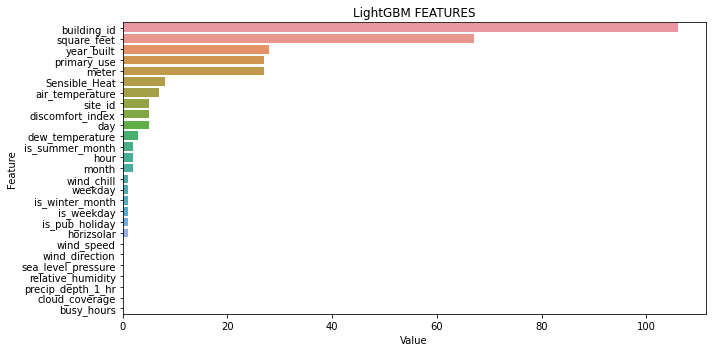

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM FEATURES')
plt.tight_layout()
plt.show()

In [ ]:
df = data[['building_id','square_feet','year_built','primary_use','meter','Sensible_Heat','air_temperature','site_id','discomfort_index',
             'day','dew_temperature','is_summer_month','hour','month','wind_chill','weekday','is_winter_month','is_weekday',
             'is_pub_holiday','horizsolar']]

In [ ]:
df.columns

Index(['building_id', 'square_feet', 'year_built', 'primary_use', 'meter',
       'Sensible_Heat', 'air_temperature', 'site_id', 'discomfort_index',
       'day', 'dew_temperature', 'is_summer_month', 'hour', 'month',
       'wind_chill', 'weekday', 'is_winter_month', 'is_weekday',
       'is_pub_holiday', 'horizsolar'],
      dtype='object')

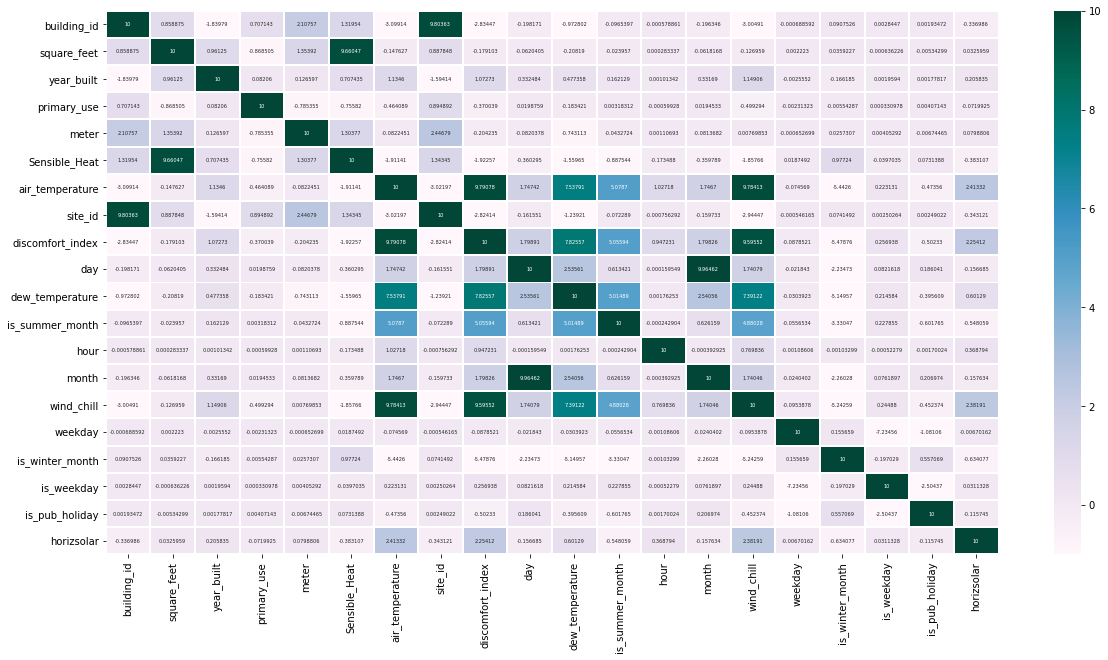

In [ ]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(df.corr()*10,vmin=-1,vmax=10,linewidths=1,annot=True,annot_kws={"size": 5},fmt="g",ax=ax,cmap='PuBuGn')

* Removing highly correlated features

In [ ]:
df.drop(['site_id','Sensible_Heat','discomfort_index','dew_temperature','is_summer_month','wind_chill','month'],axis=1,inplace=True)

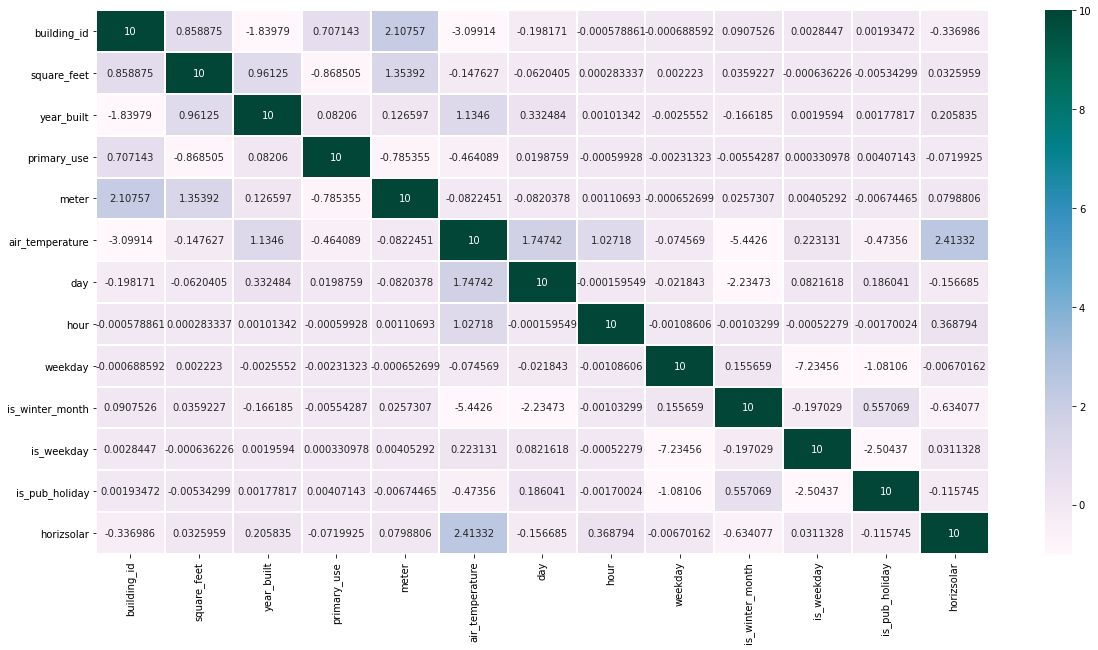

In [ ]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(df.corr()*10,vmin=-1,vmax=10,linewidths=1,annot=True,annot_kws={"size": 10},fmt="g",ax=ax,cmap='PuBuGn')